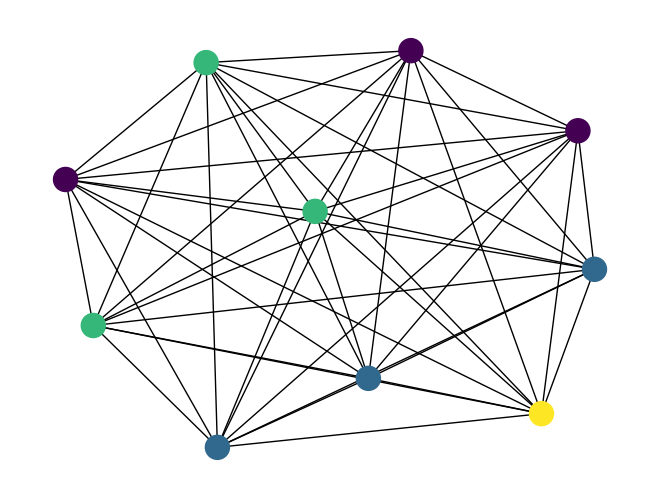

In [218]:
import networkx as nx
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np
import heapq




from itertools import product

def defective_coloring_v1(graph, threshold=2):
    # Initialize all nodes with the same color (e.g., color 0)
    colors = defaultdict(lambda: 0)

    # Create a defect number map for nodes
    defect_map = {node: len(list(graph.neighbors(node))) for node in graph.nodes()}

    # Initialize variable for the max defect value
    max_defect = max(defect_map.values())

    # Continue until no node's defect number exceeds the threshold
    while max_defect > threshold:
        # Find the node with the highest defect number
        node = max(defect_map, key=defect_map.get)

        # Previous color of the node
        old_color = colors[node]

        # Recolor the node
        colors[node] += 1
        new_color = colors[node]

        # Adjust the defect number for the recolored node
        defect_map[node] = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == new_color)

        # Adjust the defect number for the neighbors
        for neighbor in graph.neighbors(node):
            if colors[neighbor] == old_color:
                defect_map[neighbor] -= 1  # Decrease if the color was the same as the old color
            elif colors[neighbor] == new_color:
                defect_map[neighbor] += 1  # Increase if the color is the same as the new color

        # Recalculate the max defect value
        max_defect = max(defect_map.values())

    return dict(colors)  # Convert defaultdict back to regular dict for output






def defective_coloring_v2(graph, threshold=2):
    # Initialize all nodes with the same color (e.g., color 0)
    colors = defaultdict(lambda: 0)

    # Create a defect number map for nodes
    defect_map = {node: len(list(graph.neighbors(node))) for node in graph.nodes()}

    # Initialize variable for the max defect value
    max_defect = max(defect_map.values())

    # Continue until no node's defect number exceeds the threshold
    color=0
    while max_defect > threshold:
        # Find the node with the highest defect number
        node = max(defect_map, key=defect_map.get)

        # Previous color of the node
        old_color = colors[node]

        # Recolor the node with +1 of max neighbor color if min neighbor color is 0
        colors[node] = max([colors[neighbor] for neighbor in graph.neighbors(node)])+1 if min([colors[neighbor] for neighbor in graph.neighbors(node)])==0 else min([colors[neighbor] for neighbor in graph.neighbors(node)])-1
        color += 1
        new_color = colors[node]

        # Adjust the defect number for the recolored node
        defect_map[node] = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == new_color)

        # Adjust the defect number for the neighbors
        for neighbor in graph.neighbors(node):
            if colors[neighbor] == old_color:
                defect_map[neighbor] -= 1  # Decrease if the color was the same as the old color
            elif colors[neighbor] == new_color:
                defect_map[neighbor] += 1  # Increase if the color is the same as the new color

        # Recalculate the max defect value
        max_defect = max(defect_map.values())

    return dict(colors)  # Convert defaultdict back to regular dict for output







def defective_coloring_heap(graph, threshold=2):
    # Initialize all nodes with the same color (e.g., color 0)
    colors = defaultdict(lambda: 0)

    # Create a defect number map for nodes
    defect_map = {node: sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == 0) 
                  for node in graph.nodes()}

    # Create a priority queue for nodes with the highest defect number
    pq = []
    for node, defect in defect_map.items():
        heapq.heappush(pq, (-defect, node))

    # Continue until no node's defect number exceeds the threshold
    while max(defect_map.values()) > threshold:
        # Find the node with the highest defect number
        defect, node = heapq.heappop(pq)

        # Recolor the node
        colors[node] += 1

        # Update defect map for the node and its neighbors
        for n in set([node] + list(graph.neighbors(node))):
            defect_map[n] = sum(1 for neighbor in graph.neighbors(n) if colors[neighbor] == colors[n])

            # Add the node with the updated defect number to the priority queue
            heapq.heappush(pq, (-defect_map[n], n))

    return dict(colors)  # Convert defaultdict back to regular dict for output


# Example usage with 300 nodes and 1000 edges
G = nx.erdos_renyi_graph(10, 30)
threshold = 2
colors = defective_coloring_v1(G, threshold)

# Color nodes based on computed coloring  
nx.draw(G, node_color=[colors[node] for node in G.nodes()])


In [203]:
def is_valid_coloring(graph, colors, threshold):
    """
    Check if the coloring is valid (no node has a defect number greater than the threshold).
    """
    for node in graph.nodes():
        defect = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == colors[node])
        if defect > threshold:
            return False
    return True


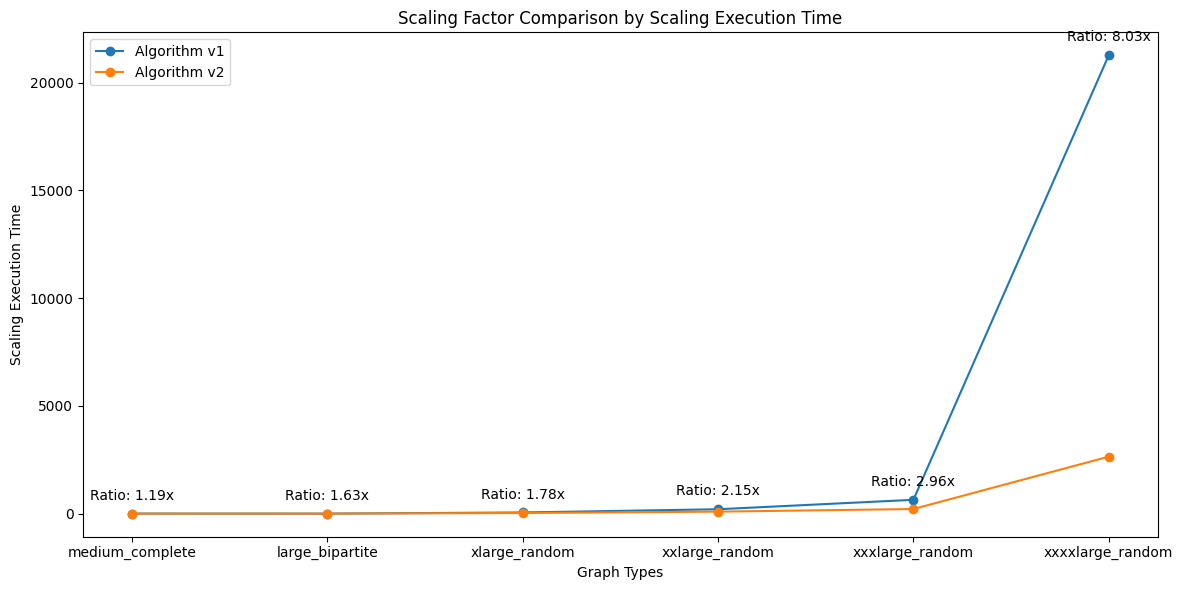

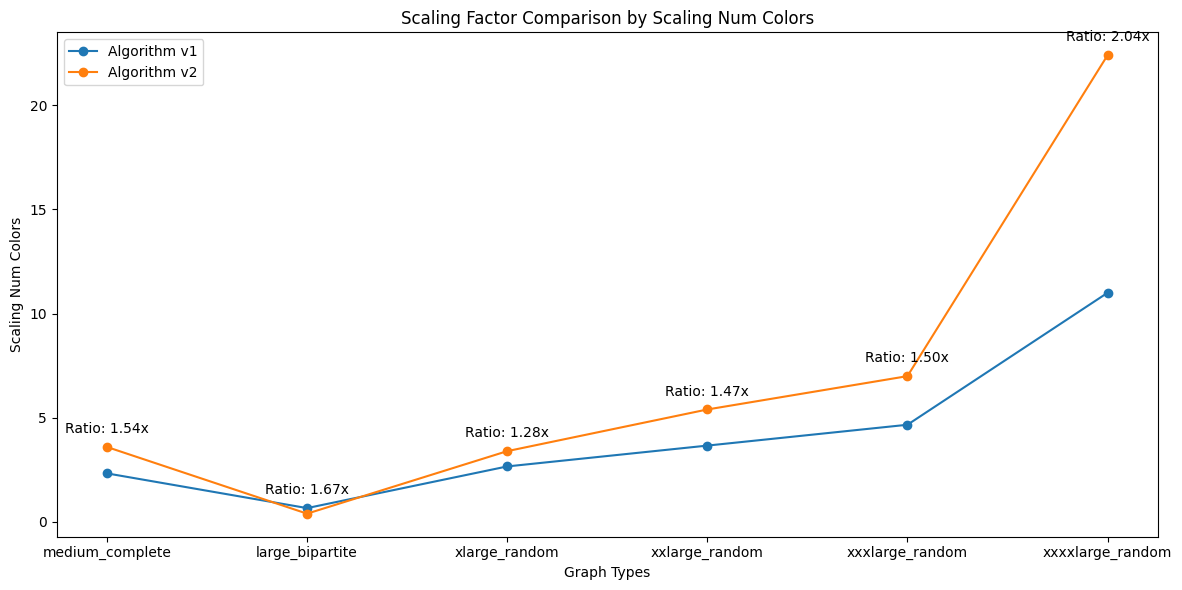

In [219]:
# Enhanced graph generation
def generate_test_graphs():
    return {
        "small_random": nx.erdos_renyi_graph(10, 0.5),
        "medium_complete": nx.complete_graph(20),
        "large_bipartite": nx.bipartite.random_graph(25, 25, 0.4),
        "xlarge_random": nx.erdos_renyi_graph(100, 0.3),
        "xxlarge_random": nx.erdos_renyi_graph(200, 0.2),
        "xxxlarge_random": nx.erdos_renyi_graph(300, 0.2),
        "xxxxlarge_random": nx.erdos_renyi_graph(1000, 0.2),
    }

# Benchmarking function
def benchmark_coloring_algorithm(graph, algorithm):
    start_time = time.time()
    colors = algorithm(graph)
    end_time = time.time()
    num_colors = len(set(colors.values()))
    return end_time - start_time, num_colors

# Main benchmark execution
def main():
    graphs = generate_test_graphs()
    results = {}
    baseline = {}
    for graph_name, graph in graphs.items():
        results[graph_name] = {}
        for algorithm in [defective_coloring_v1, defective_coloring_v2]:
            exec_time, num_colors = benchmark_coloring_algorithm(graph, algorithm)
            results[graph_name][algorithm.__name__] = {
                "execution_time": exec_time,
                "num_colors": num_colors
            }
            # Calculate scaling factor compared to the baseline (smallest graph)
            if graph_name == "small_random":
                baseline[algorithm.__name__] = (exec_time, num_colors)
            else:
                scaling_exec_time = exec_time / baseline[algorithm.__name__][0] if baseline[algorithm.__name__][0] > 0 else 0
                scaling_num_colors = num_colors / baseline[algorithm.__name__][1] if baseline[algorithm.__name__][1] > 0 else 0
                results[graph_name][algorithm.__name__].update({
                    "scaling_execution_time": scaling_exec_time,
                    "scaling_num_colors": scaling_num_colors
                })
    return results

# Enhanced plotting function with line plot for execution time scaling factor



def plot_scaling_results(benchmark_results):
    scaling_metrics = ['scaling_execution_time', 'scaling_num_colors']
    algorithms = ['defective_coloring_v1', 'defective_coloring_v2']
    graph_types = list(benchmark_results.keys())[1:]  # Exclude the baseline graph

    for metric in scaling_metrics:
        plt.figure(figsize=(12, 6))
        
        # Collect values for each algorithm
        values = {alg: [benchmark_results[graph][alg].get(metric, 0) for graph in graph_types] for alg in algorithms}
        
        for alg in algorithms:
            plt.plot(graph_types, values[alg], label=f'Algorithm {alg[-2:]}', marker='o')

        # Annotate the ratio of the values for each graph type
        # Annotate the ratio of larger value to smaller value for each graph type
        for i, graph in enumerate(graph_types):
            v1, v2 = values['defective_coloring_v1'][i], values['defective_coloring_v2'][i]

            # Avoid division by zero and determine which value is larger
            if v1 > 0 and v2 > 0:
                ratio = max(v1, v2) / min(v1, v2)
                label = f'Ratio: {ratio:.2f}x'
            else:
                label = 'N/A'  # Case when either of the values is zero

            plt.annotate(label, (i, max(v1, v2)), textcoords="offset points", xytext=(0,10), ha='center')


        plt.xlabel('Graph Types')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.title(f'Scaling Factor Comparison by {metric.replace("_", " ").title()}')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    benchmark_results = main()  # Ensure the main function is defined and returns benchmark_results
    plot_scaling_results(benchmark_results)






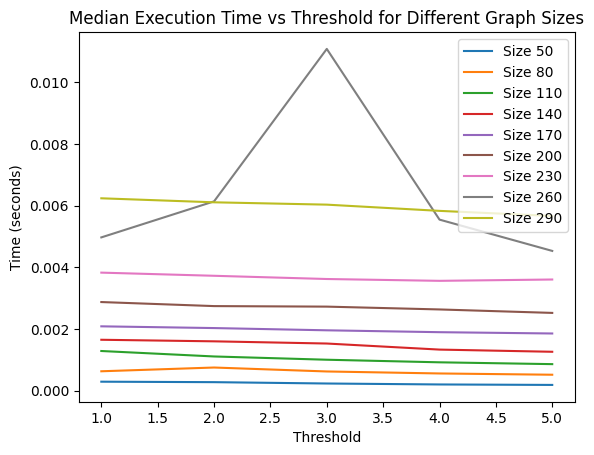

All tests passed.


True

In [193]:
def test_defective_coloring_with_timing():
    graph_sizes = range(50, 300, 30)  # Range of graph sizes
    thresholds = range(1, 6)  # Range of thresholds
    num_tests = 5  # Number of tests per combination of graph size and threshold
    timing_results = {size: {threshold: [] for threshold in thresholds} for size in graph_sizes}

    for size in graph_sizes:
        for threshold in thresholds:
            times = []
            for _ in range(num_tests):
                graph = nx.erdos_renyi_graph(size, 0.2)
                start_time = time.time()
                colors = defective_coloring_v2(graph, threshold)
                elapsed_time = time.time() - start_time

                if not is_valid_coloring(graph, colors, threshold):
                    print(f"Test failed for graph size {size} with threshold {threshold}")
                    return False

                times.append(elapsed_time)

            # Store the median time for this graph size and threshold
            timing_results[size][threshold] = np.median(times)

    # Plotting
    for size in graph_sizes:
        median_times = [timing_results[size][threshold] for threshold in thresholds]
        plt.plot(thresholds, median_times, label=f'Size {size}')

    plt.xlabel('Threshold')
    plt.ylabel('Time (seconds)')
    plt.title('Median Execution Time vs Threshold for Different Graph Sizes')
    plt.legend()
    plt.show()

    print("All tests passed.")
    return True

# Run the test with timing
test_defective_coloring_with_timing()


In [220]:
# Create a sample graph
G = nx.erdos_renyi_graph(n=10, p=0.3)

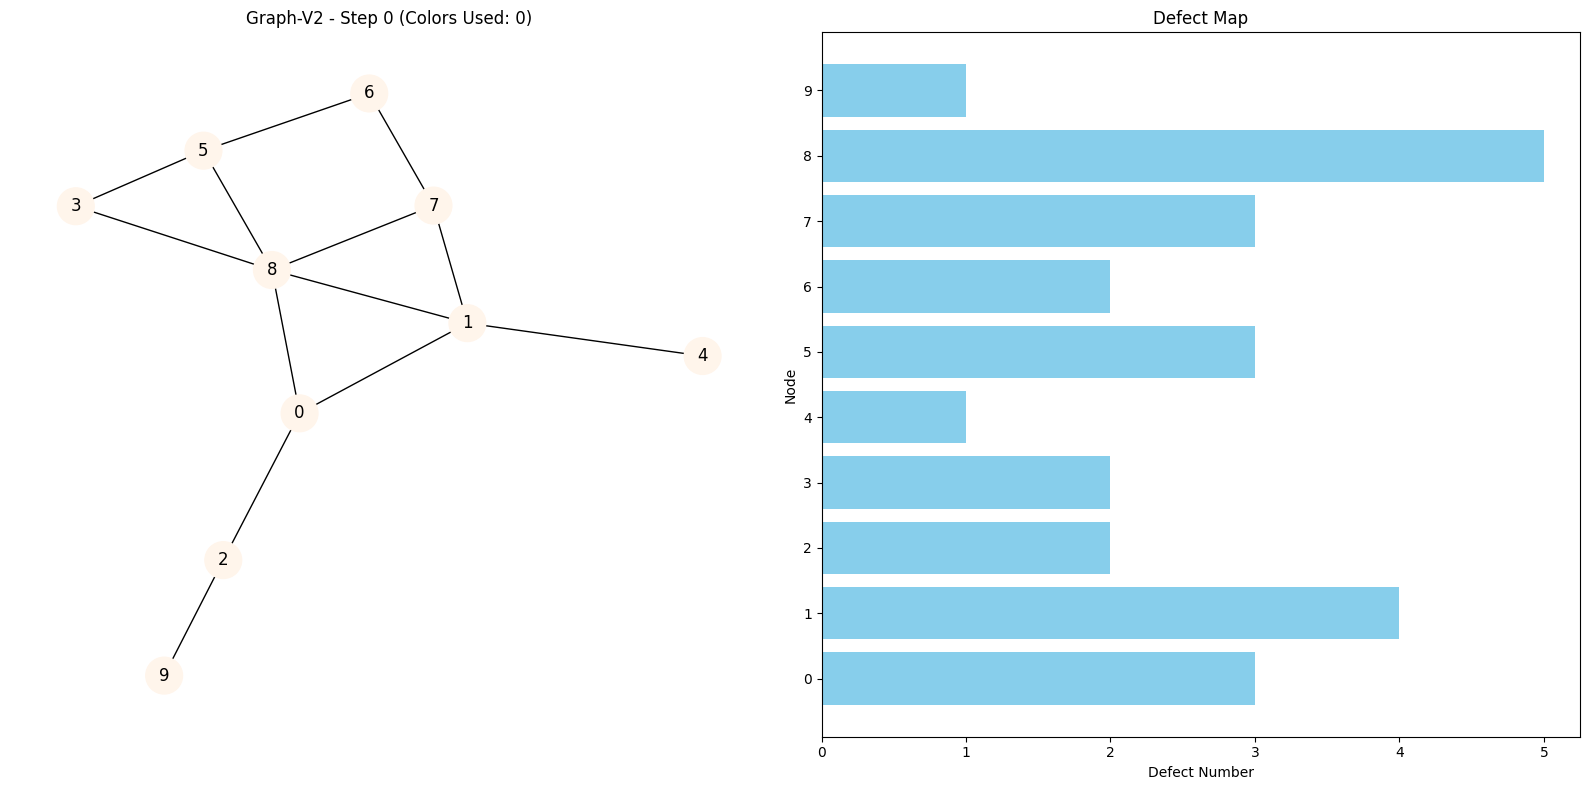

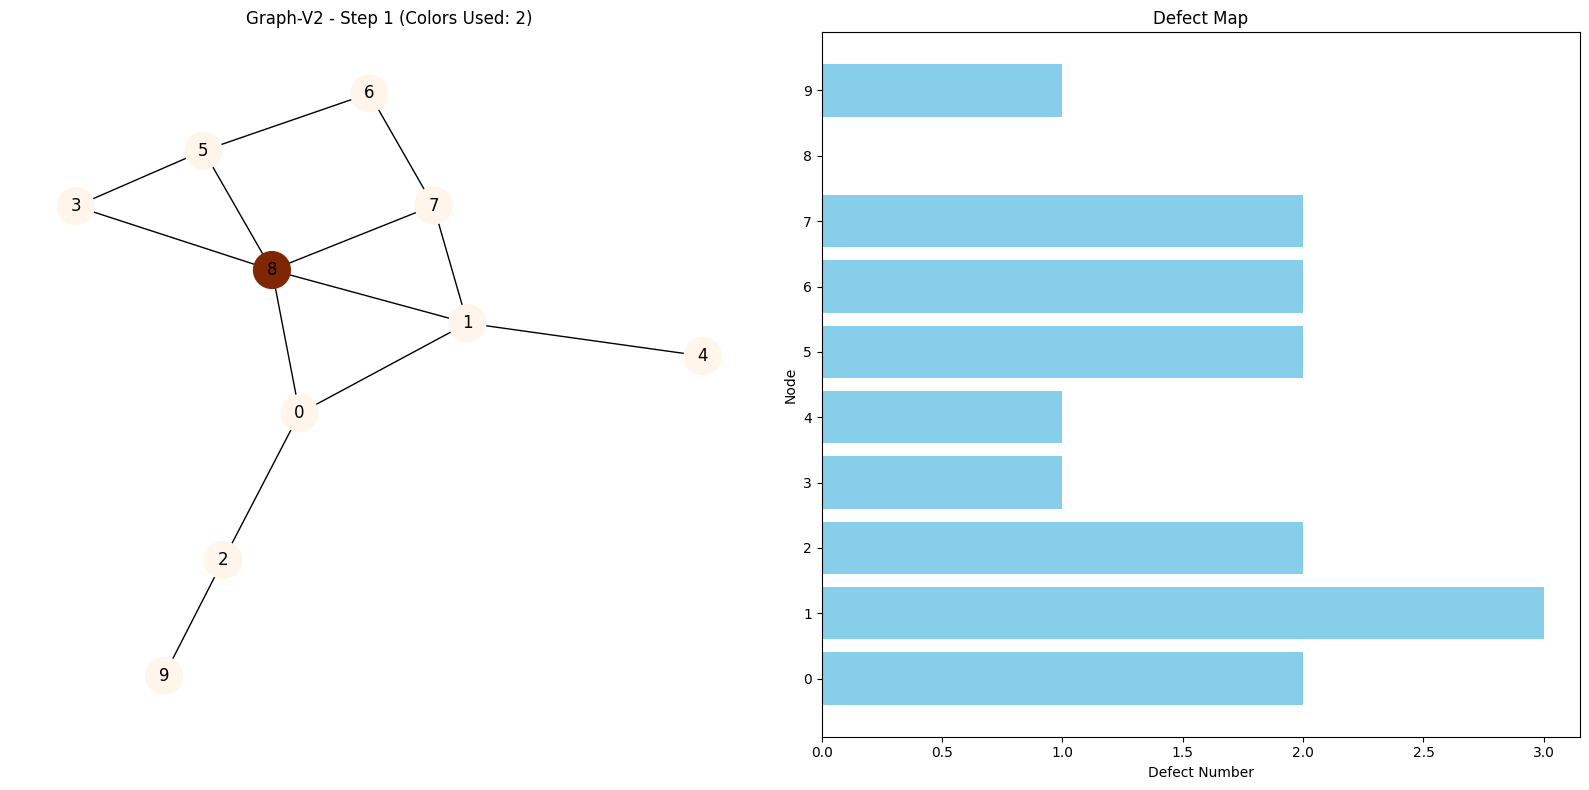

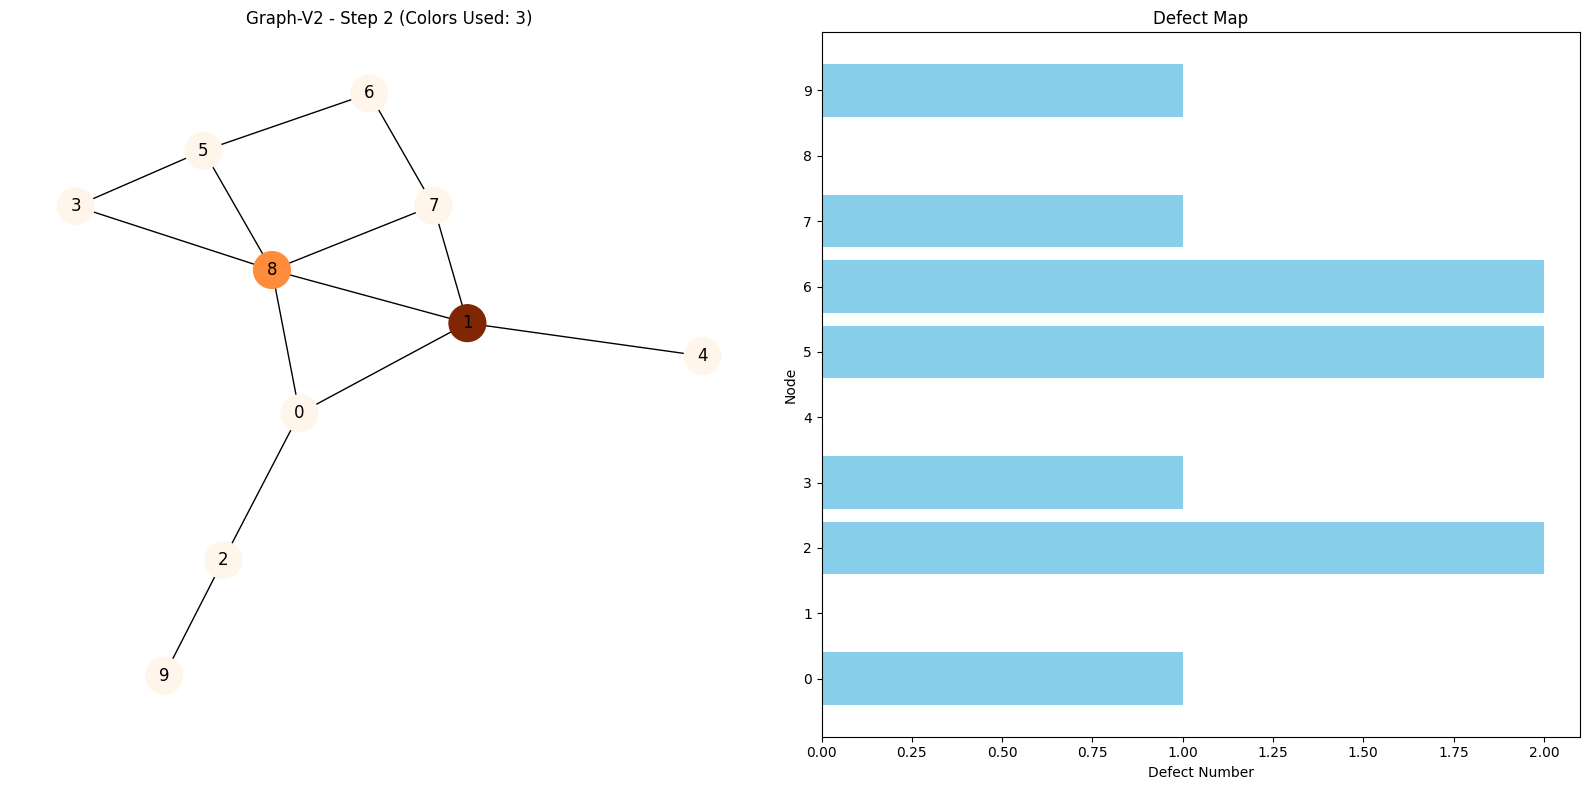

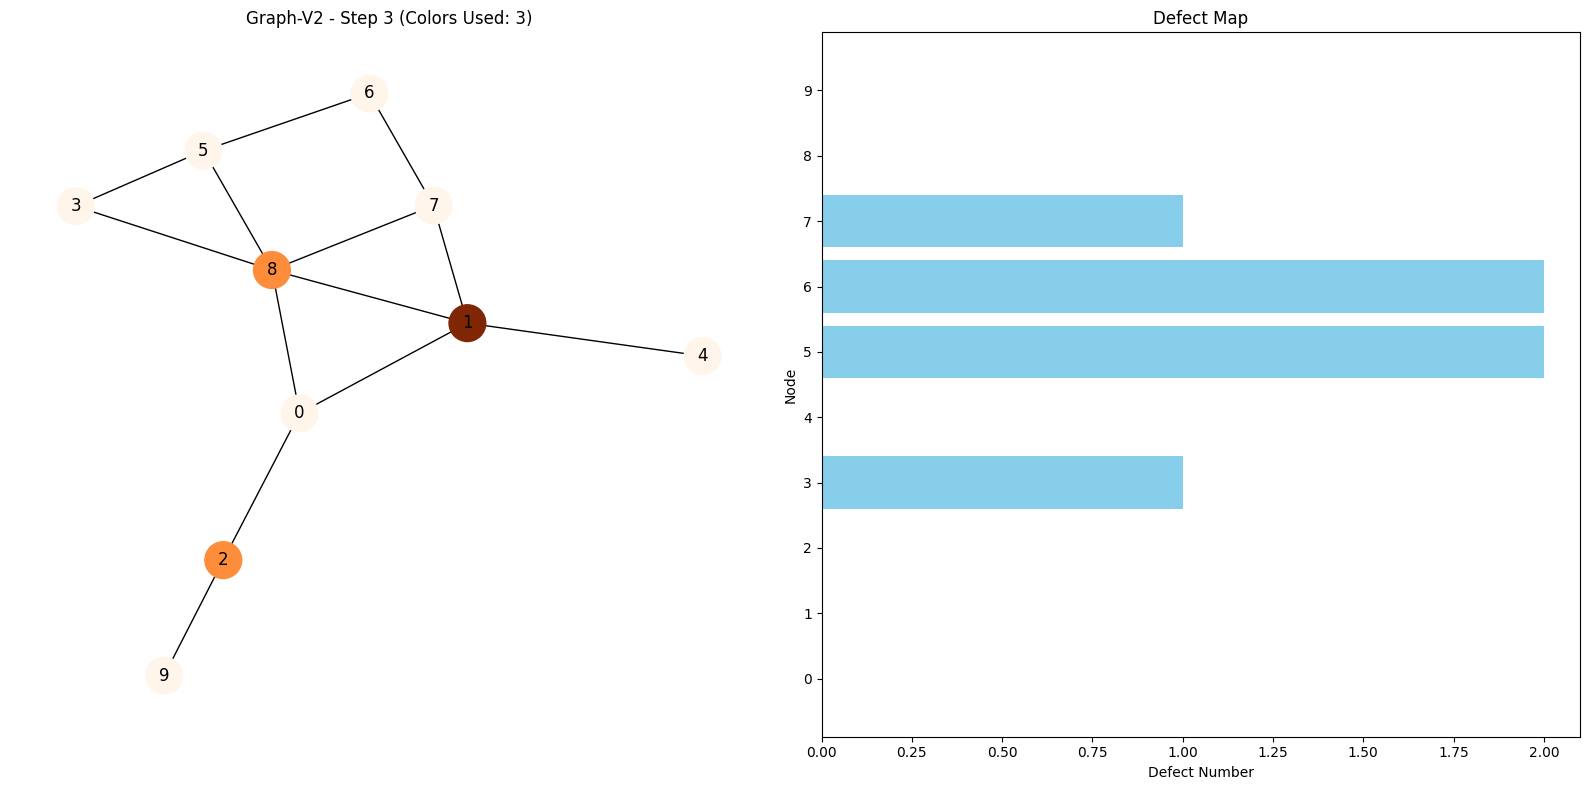

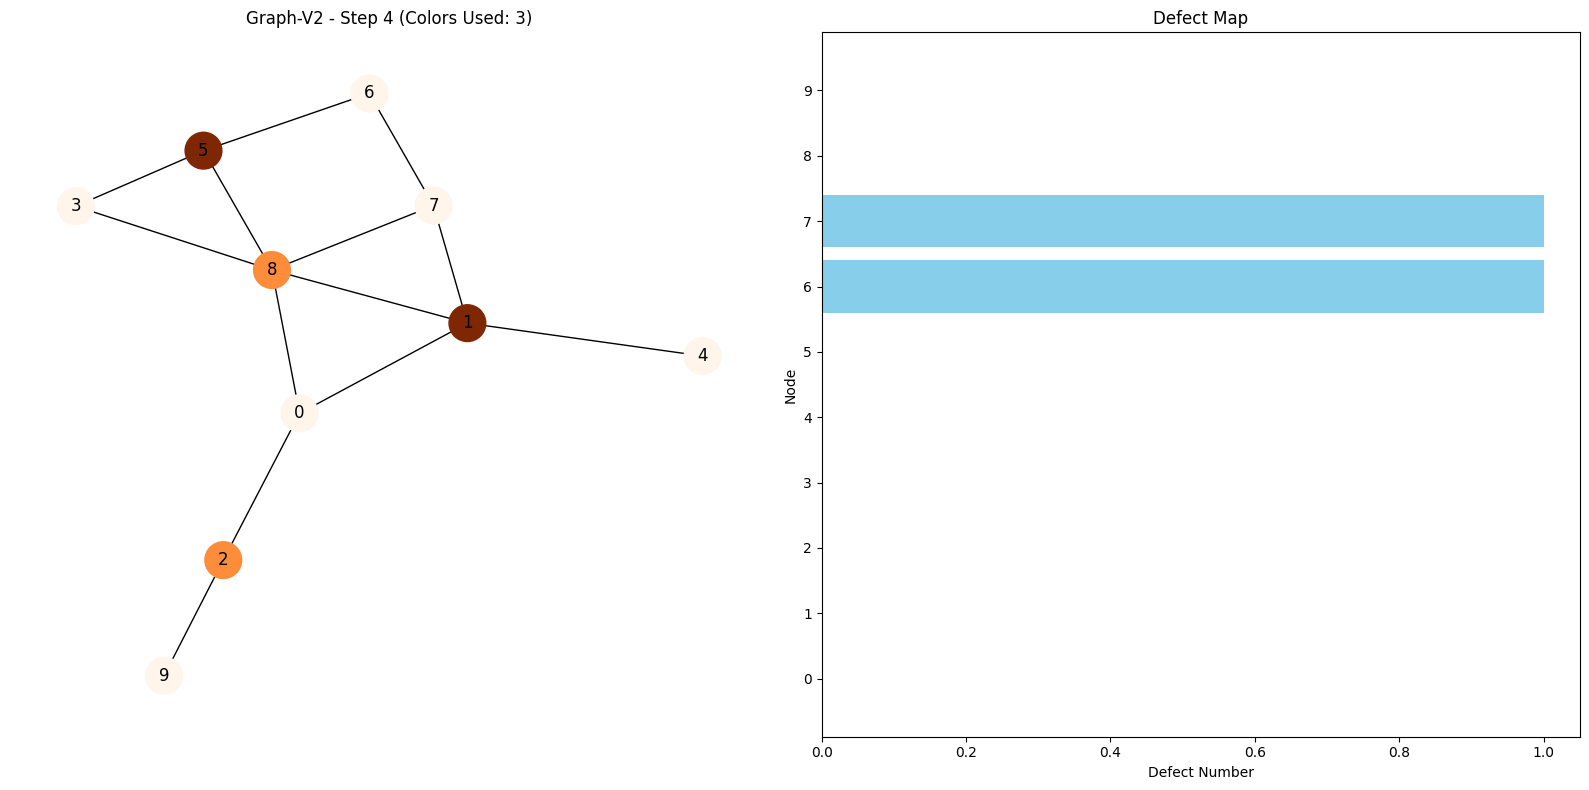

In [222]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

def defective_coloring_v2(graph, threshold=1):
    colors = defaultdict(lambda: 0)
    defect_map = {node: len(list(graph.neighbors(node))) for node in graph.nodes()}
    max_defect = max(defect_map.values())

    # Yield initial state for visualization
    yield dict(colors), dict(defect_map), len(set(colors.values()))

    color = 0
    while max_defect > threshold:
        node = max(defect_map, key=defect_map.get)
        old_color = colors[node]
        colors[node] = max([colors[neighbor] for neighbor in graph.neighbors(node)])+1 if min([colors[neighbor] for neighbor in graph.neighbors(node)])==0 else min([colors[neighbor] for neighbor in graph.neighbors(node)])-1

        new_color = colors[node]

        defect_map[node] = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == new_color)

        for neighbor in graph.neighbors(node):
            if colors[neighbor] == old_color:
                defect_map[neighbor] -= 1
            elif colors[neighbor] == new_color:
                defect_map[neighbor] += 1

        max_defect = max(defect_map.values())

        # Yield state after each update for visualization
        yield dict(colors), dict(defect_map), len(set(colors.values()))



# Fix the position of the graph
pos = nx.spring_layout(G, seed=42)  # Fixed layout

# Visualization function
def visualize_graph(G, color_map, defect_map, color_count, step, pos):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plotting the graph
    ax1.set_title(f"Graph-V2 - Step {step} (Colors Used: {color_count})")
    colors = [color_map.get(node, 0) for node in G.nodes()]
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=colors, cmap=plt.cm.Oranges, node_size=700)

    # Displaying the defect map
    ax2.set_title("Defect Map")
    ax2.barh(list(defect_map.keys()), list(defect_map.values()), color='skyblue')
    ax2.set_xlabel('Defect Number')
    ax2.set_ylabel('Node')
    ax2.set_yticks(list(defect_map.keys()))
    ax2.set_yticklabels(list(defect_map.keys()))

    plt.tight_layout()
    plt.show()

# Apply the algorithm and visualize each step
for step, (color_map, defect_map, color_count) in enumerate(defective_coloring_v2(G)):
    visualize_graph(G, color_map, defect_map, color_count, step, pos)



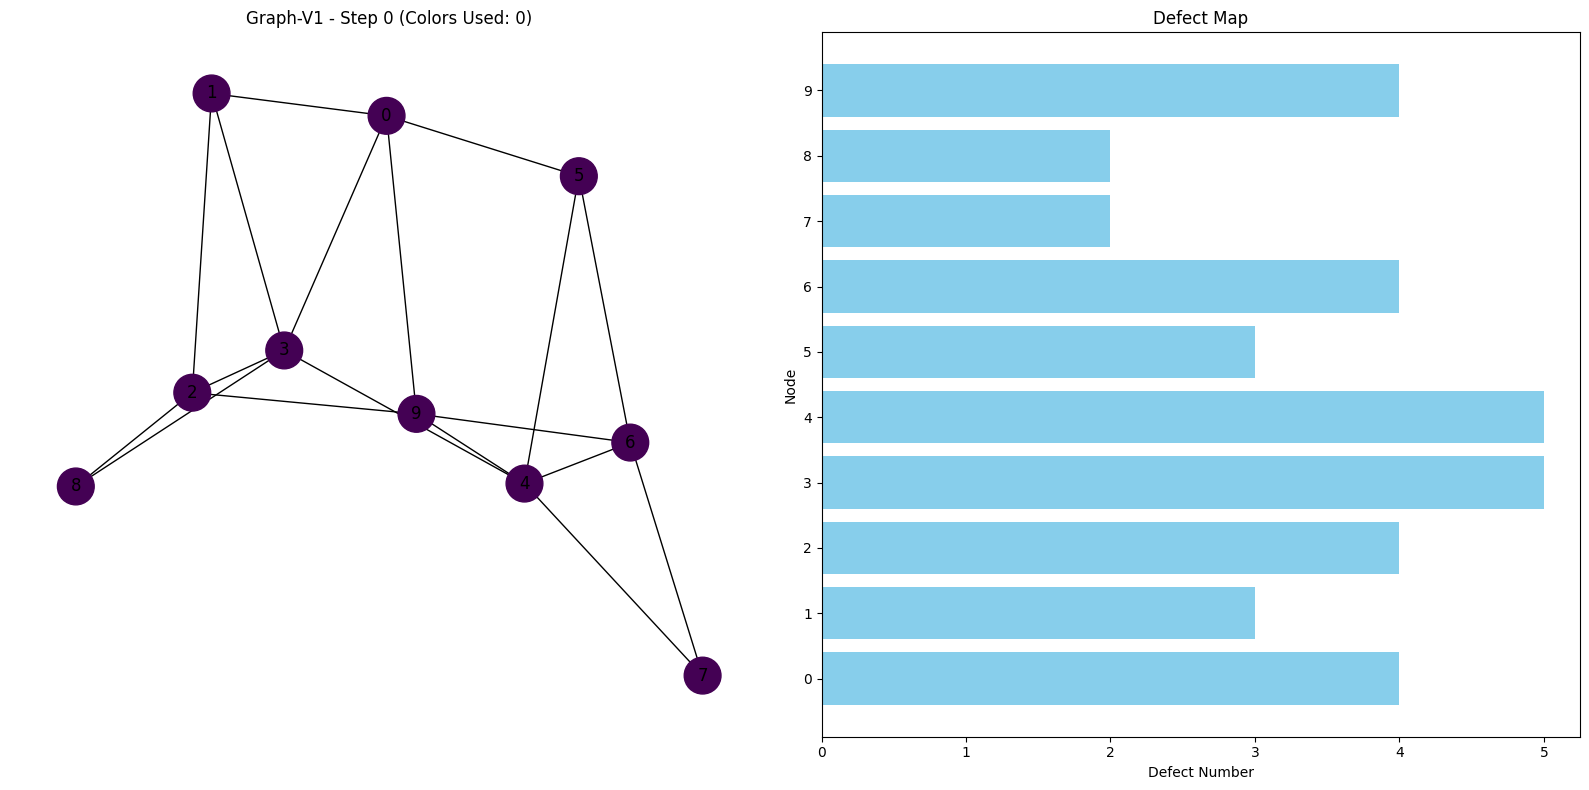

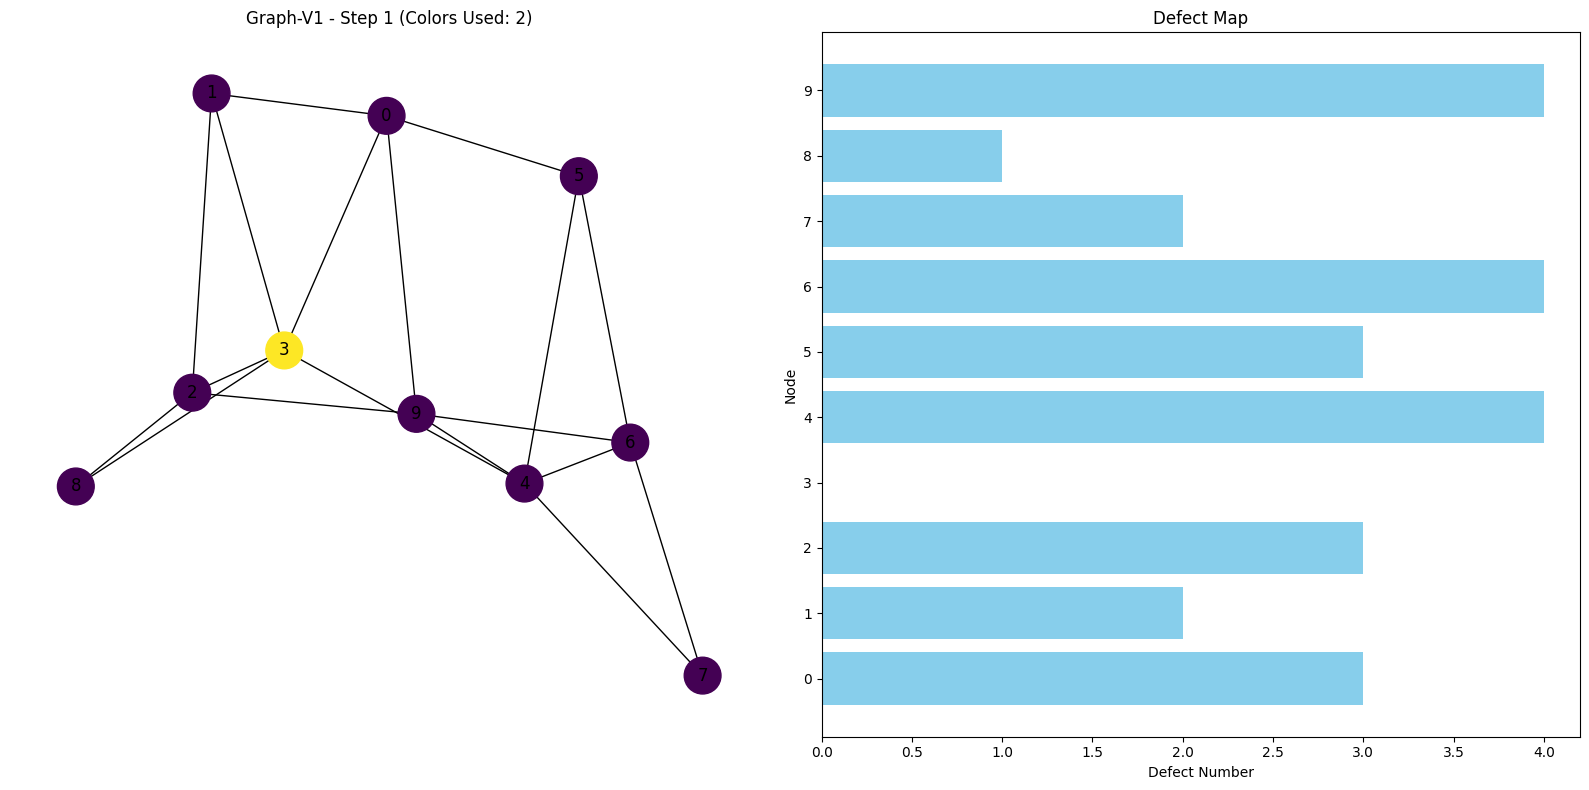

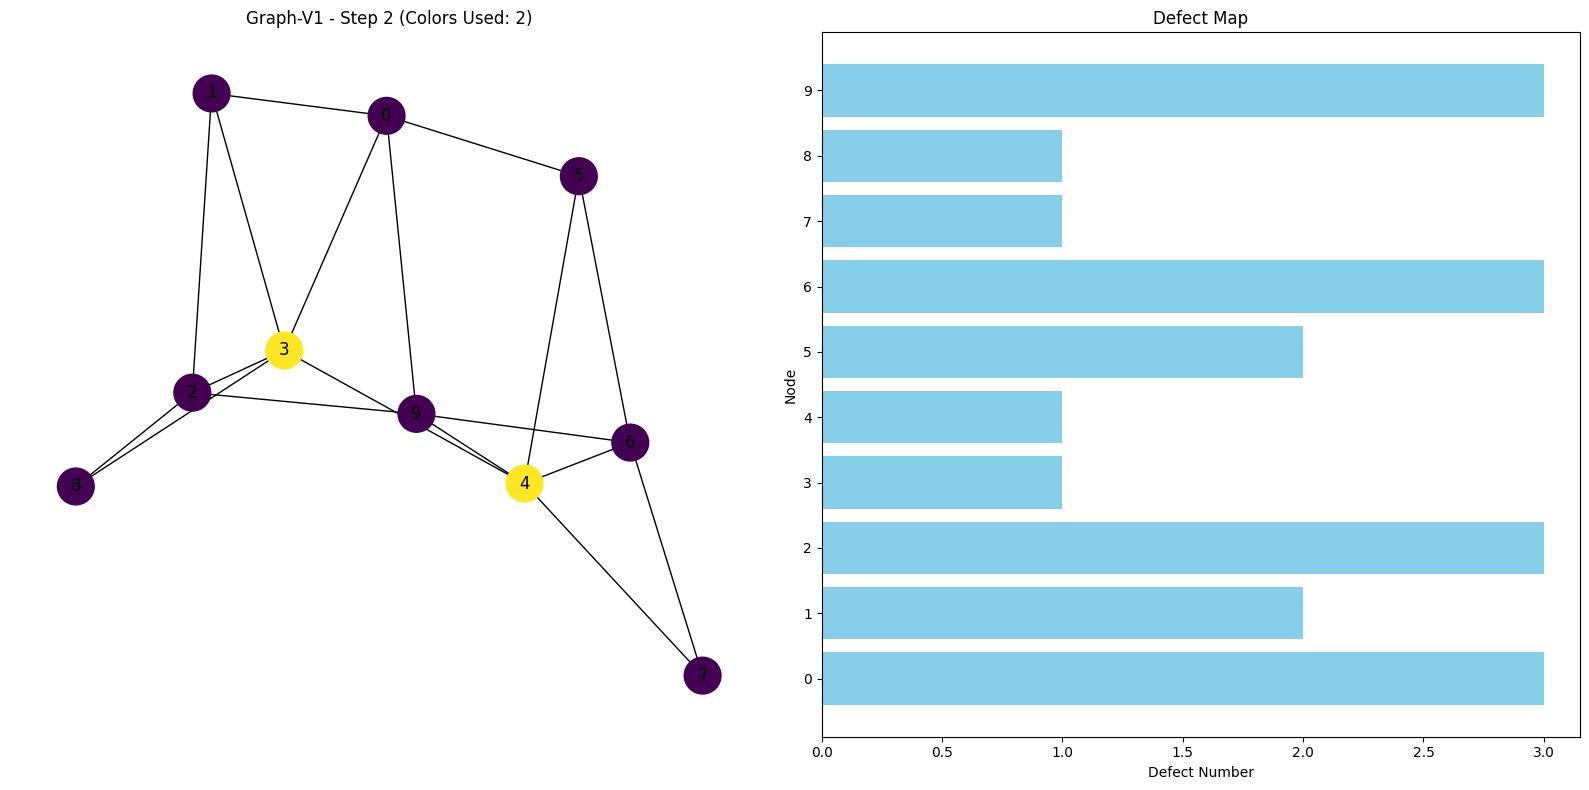

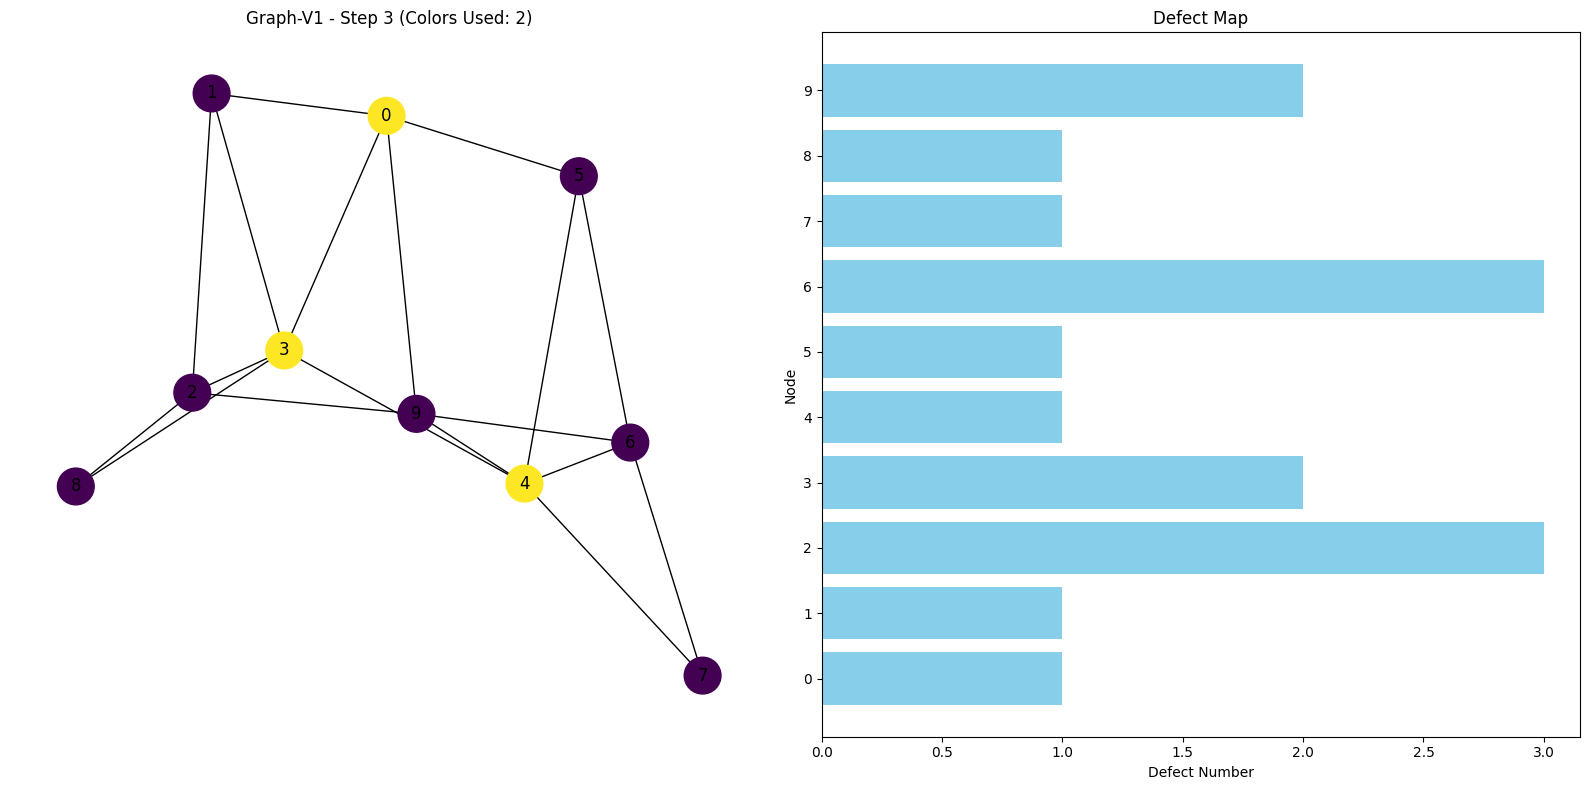

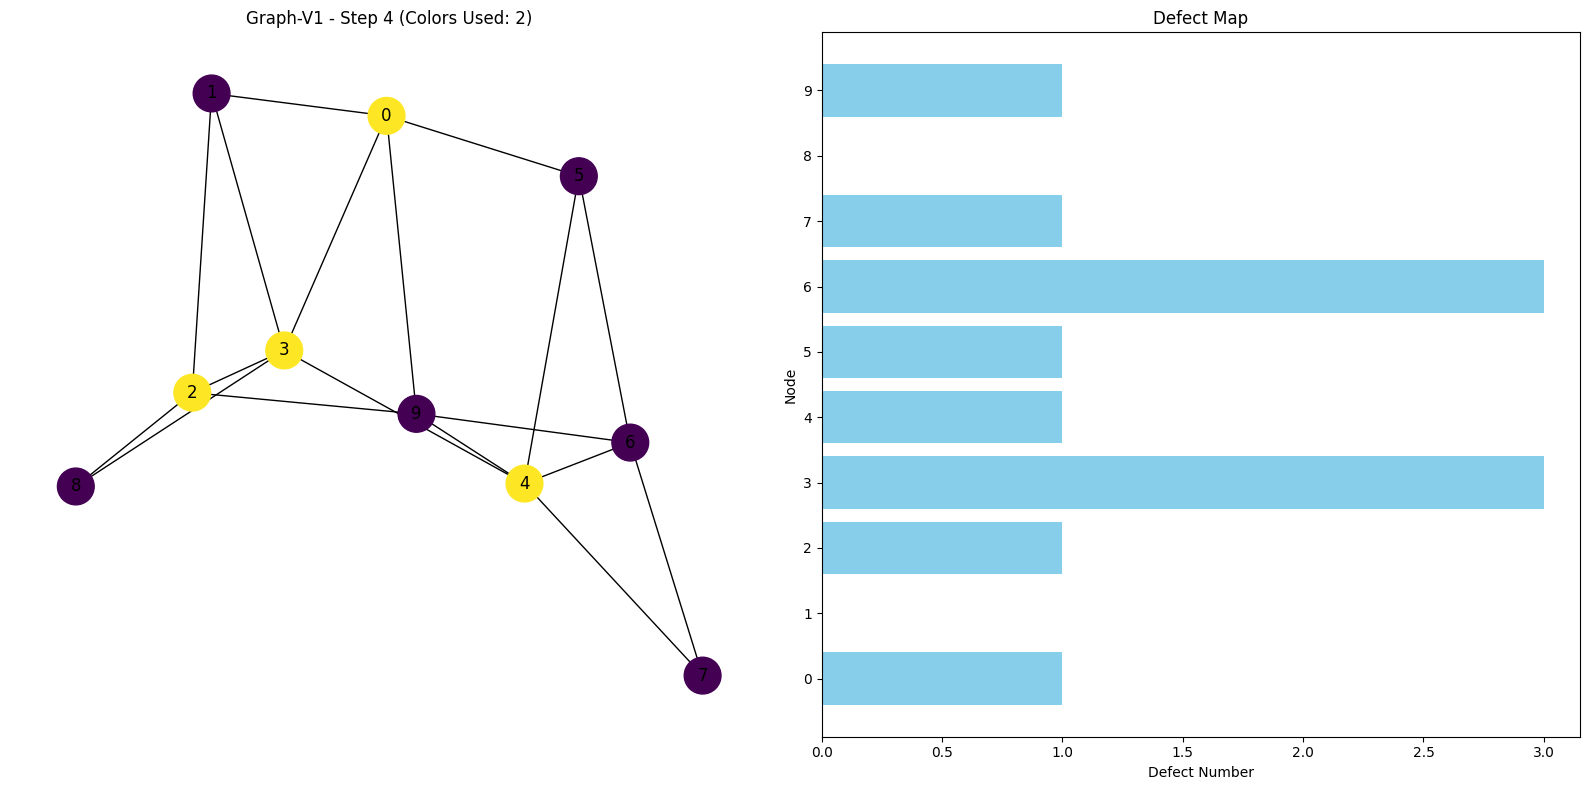

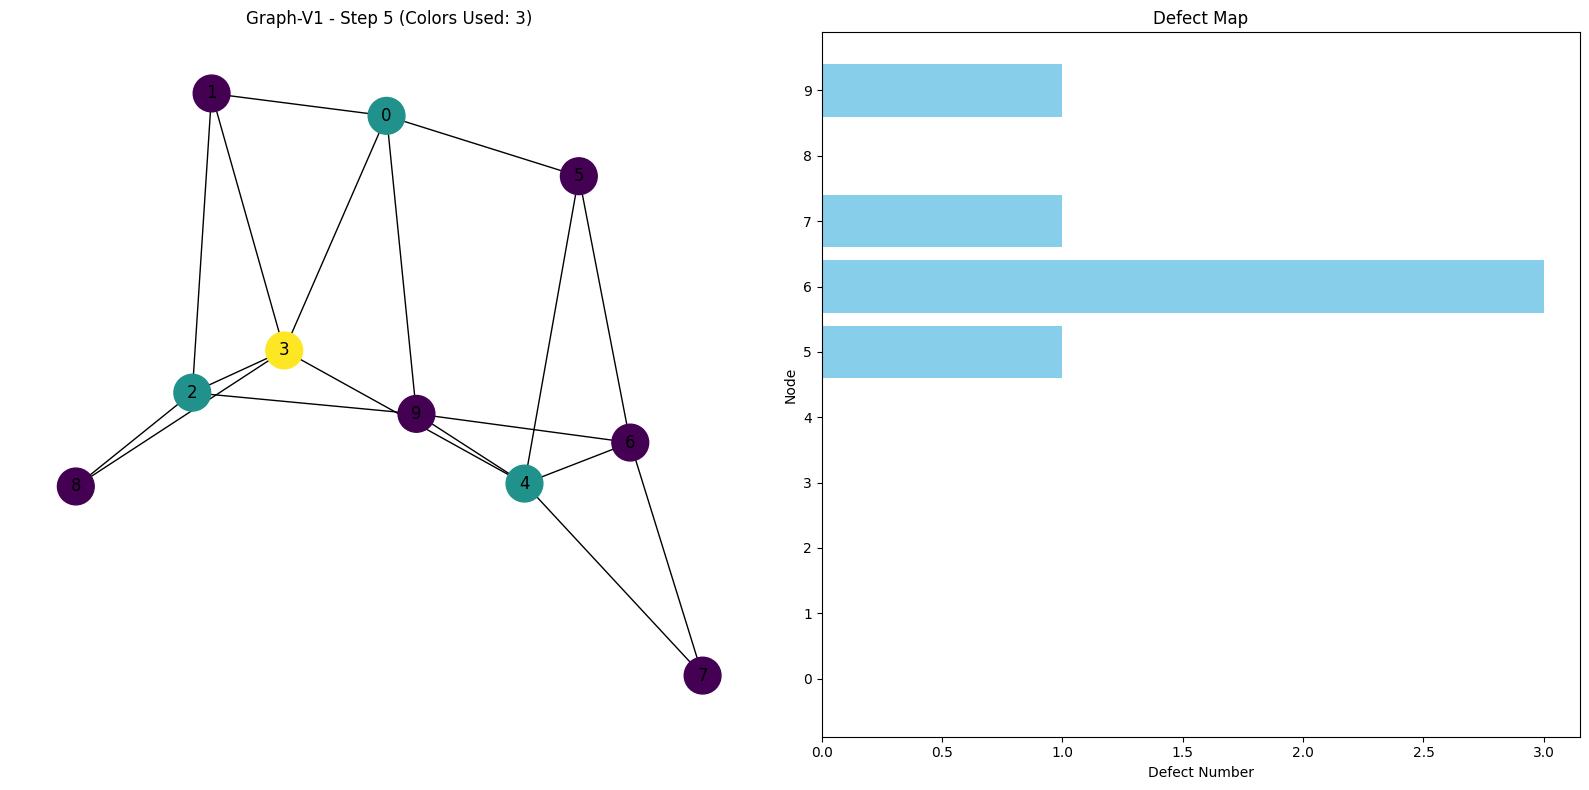

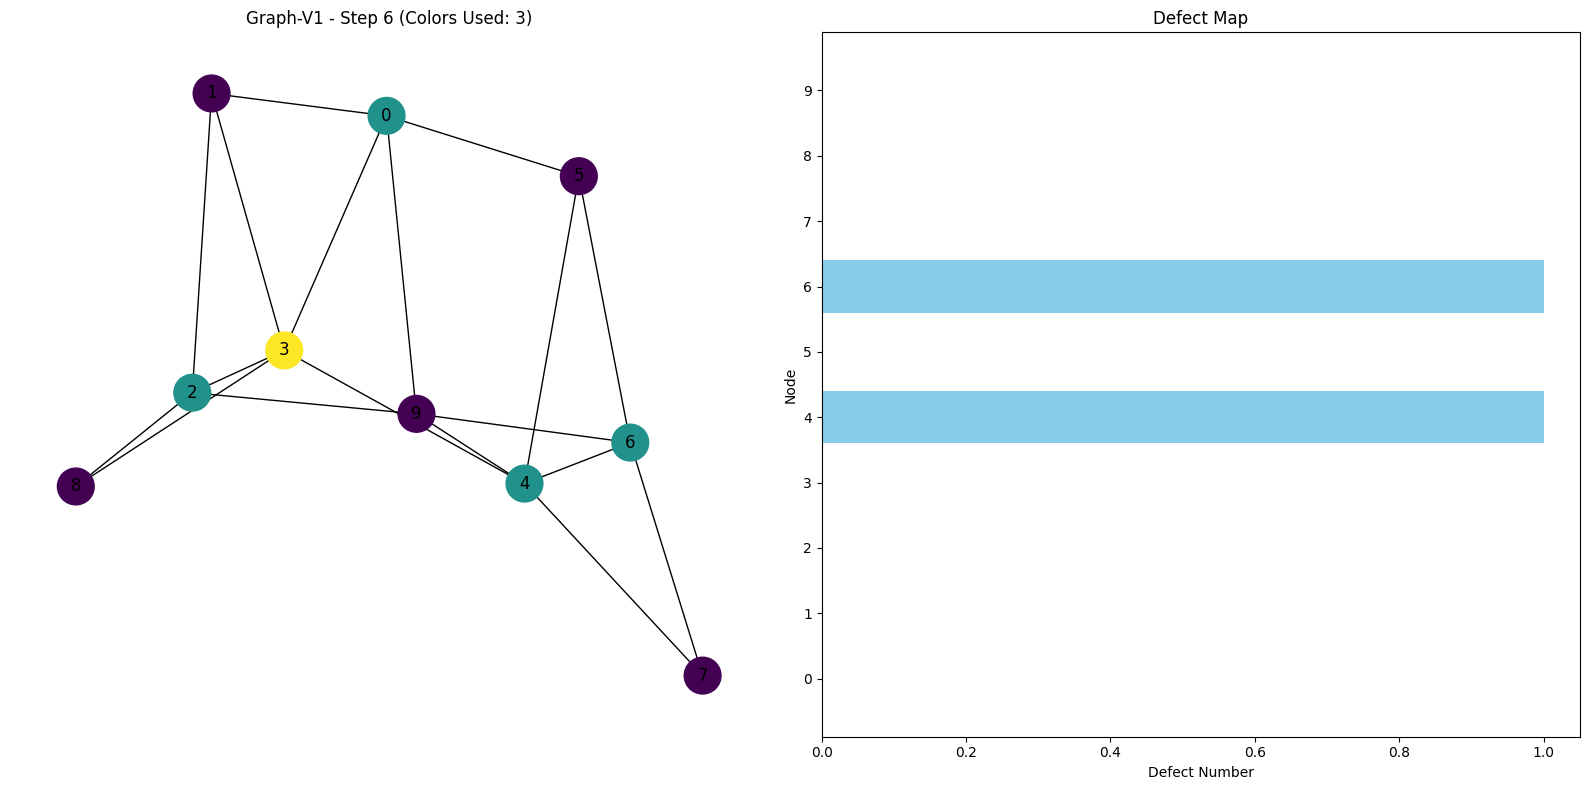

In [216]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

def defective_coloring_v1(graph, threshold=1):
    colors = defaultdict(lambda: 0)
    defect_map = {node: len(list(graph.neighbors(node))) for node in graph.nodes()}
    max_defect = max(defect_map.values())

    # Yield initial state for visualization
    yield dict(colors), dict(defect_map), len(set(colors.values()))

    while max_defect > threshold:
        node = max(defect_map, key=defect_map.get)
        old_color = colors[node]
        colors[node] += 1
        new_color = colors[node]

        defect_map[node] = sum(1 for neighbor in graph.neighbors(node) if colors[neighbor] == new_color)

        for neighbor in graph.neighbors(node):
            if colors[neighbor] == old_color:
                defect_map[neighbor] -= 1
            elif colors[neighbor] == new_color:
                defect_map[neighbor] += 1

        max_defect = max(defect_map.values())

        # Yield state after each update for visualization
        yield dict(colors), dict(defect_map), len(set(colors.values()))



# Fix the position of the graph
pos = nx.spring_layout(G, seed=42)  # Fixed layout

# Visualization function
def visualize_graph(G, color_map, defect_map, color_count, step, pos):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Plotting the graph
    ax1.set_title(f"Graph-V1 - Step {step} (Colors Used: {color_count})")
    colors = [color_map.get(node, 0) for node in G.nodes()]
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color=colors, cmap=plt.cm.Oranges, node_size=700)

    # Displaying the defect map
    ax2.set_title("Defect Map")
    ax2.barh(list(defect_map.keys()), list(defect_map.values()), color='skyblue')
    ax2.set_xlabel('Defect Number')
    ax2.set_ylabel('Node')
    ax2.set_yticks(list(defect_map.keys()))
    ax2.set_yticklabels(list(defect_map.keys()))

    plt.tight_layout()
    plt.show()

# Apply the algorithm and visualize each step
for step, (color_map, defect_map, color_count) in enumerate(defective_coloring_v1(G)):
    visualize_graph(G, color_map, defect_map, color_count, step, pos)
